# First Objective: Velocity Packet Tracker Visualisation

## Google Summer of Code 2024

Author: Sarthak Srivastava


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tardis import run_tardis
from tardis.io.atom_data.util import download_atom_data
from tardis.util.base import int_to_roman
from tardis.visualization import SDECPlotter

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

### 1. Run simulation and generate SDEC Plot


In [ ]:
# Download atom data
download_atom_data("kurucz_cd23_chianti_H_He")

In [ ]:
sim = run_tardis(
    "tardis_example.yml",
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="ERROR",
)

<Axes: xlabel='Wavelength $[\\mathrm{\\AA}]$', ylabel='$L_{\\lambda}$ [erg $\\mathrm{s^{-1}}$ $\\mathrm{\\AA^{-1}}$]'>

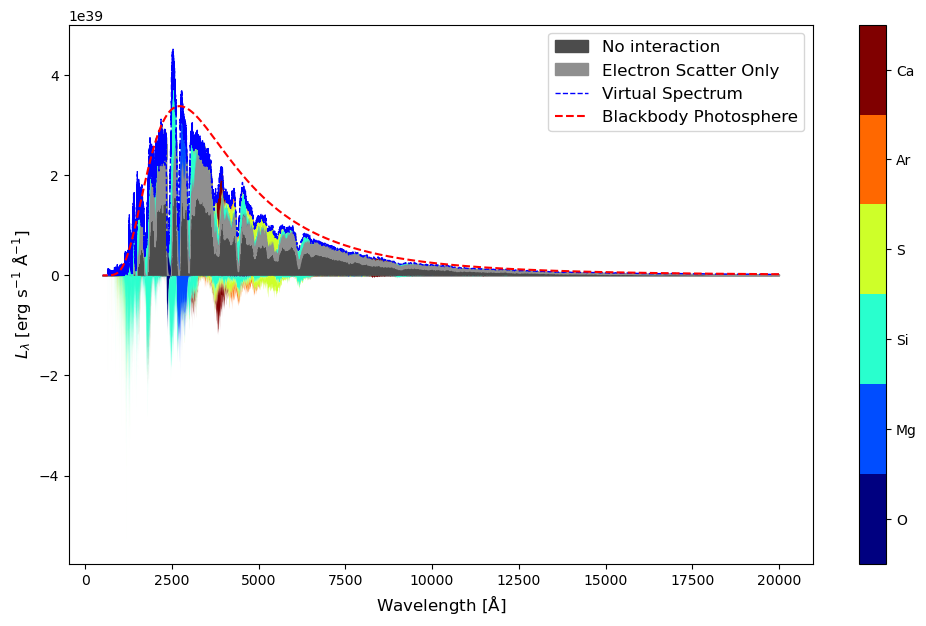

In [4]:
SDECPlotter.from_simulation(sim).generate_plot_mpl()

### 2. Abundance of Elements vs Shell Velocity


In [5]:
# Get x-axis values: shell velocities
shell_velocities = sim.simulation_state.v_inner.si
print(shell_velocities)

[11000000. 11450000. 11900000. 12350000. 12800000. 13250000. 13700000.
 14150000. 14600000. 15050000. 15500000. 15950000. 16400000. 16850000.
 17300000. 17750000. 18200000. 18650000. 19100000. 19550000.] m / s


In [6]:
# Get y-axis values: element abundances
abundances = sim.plasma.abundance
abundances

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
atomic_number,,,,,,,,,,,,,,,,,,,,
8,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
12,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
14,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52
16,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
18,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04
20,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03


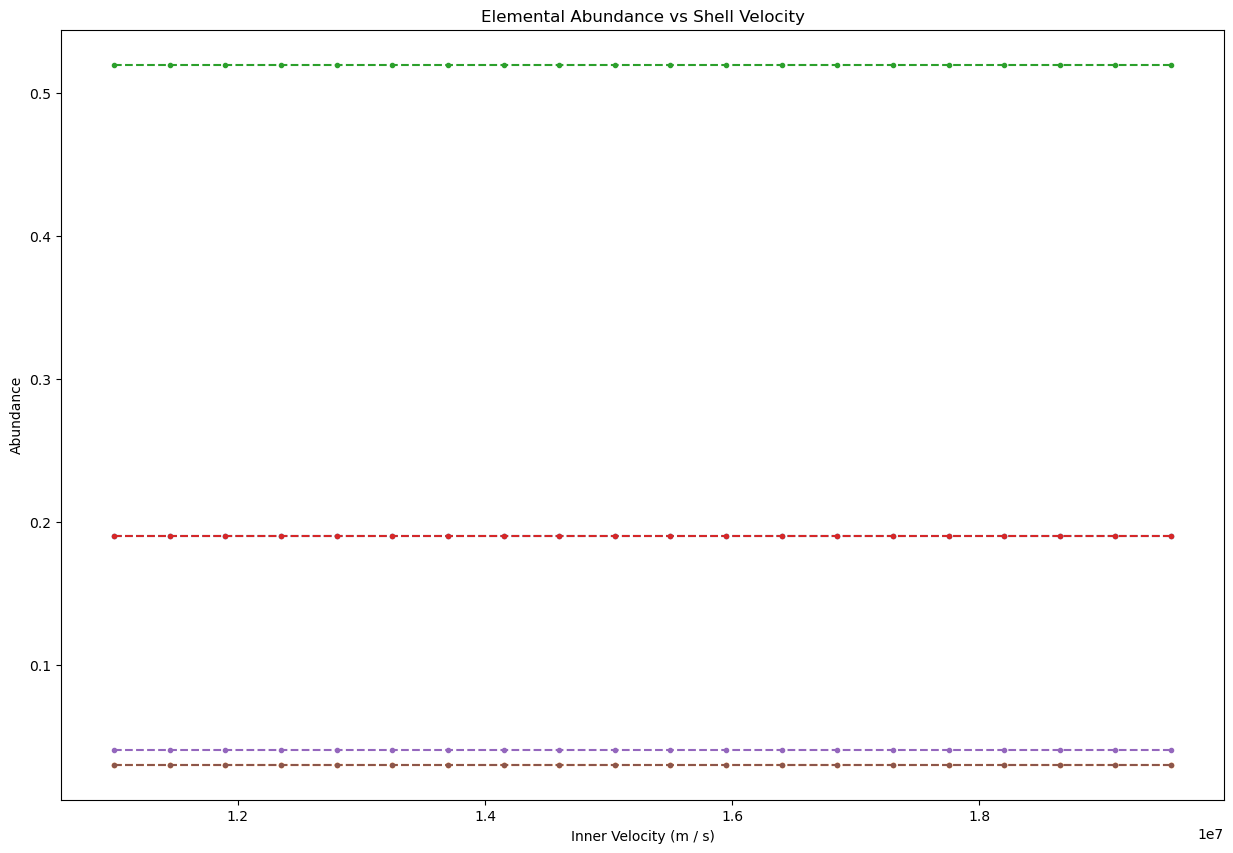

In [7]:
# Plot data
fig, axis = plt.subplots(figsize=(15, 10))

ATOM_DATA = sim.plasma.atomic_data.atom_data

for atomic_number in sim.plasma.selected_atoms:
    axis.step(
        shell_velocities,
        abundances.loc[atomic_number],
        marker=".",
        linestyle="--",
        where="post",
        label=ATOM_DATA.symbol.loc[atomic_number],
    )

_ = axis.set(
    title="Elemental Abundance vs Shell Velocity",
    xlabel=f"Inner Velocity ({str(shell_velocities.unit)})",
    ylabel="Abundance",
)

### 3. Number of interactions (escaped) for each element


In [8]:
LINE_REFERENCE = sim.plasma.atomic_data.lines  # To look up line data by ID

In [9]:
def interaction_count_by_ion(line_ids):
    """
    Looks up the line_ids in the line reference table and counts the interactions grouping by (atomic_number, ion_number)
    Returns a pd.Series with index containing ion name (Eg: "Si II") and corresponding interaction count.
    """
    # Filter out non-escaped packets
    line_ids = [line_id for line_id in line_ids if line_id != -1]

    # Group by ion
    num_lines_per_ion = (
        LINE_REFERENCE.iloc[line_ids]
        .groupby(level=["atomic_number", "ion_number"])
        .size()
    )

    # Create and return new Series
    combined_idx = num_lines_per_ion.index.map(
        lambda x: f"{ATOM_DATA.symbol.loc[x[0]]} {int_to_roman(x[1]+1)}"
    )
    combined_idx.name = "Ion"
    return pd.Series(
        num_lines_per_ion.values, index=combined_idx, name="interaction_count"
    )

In [12]:
# Get line interaction IDs and compute counts by ion
out_lines = sim.transport.transport_state.last_line_interaction_out_id

# Get count per ion
out_line_count_by_element = interaction_count_by_ion(out_lines)

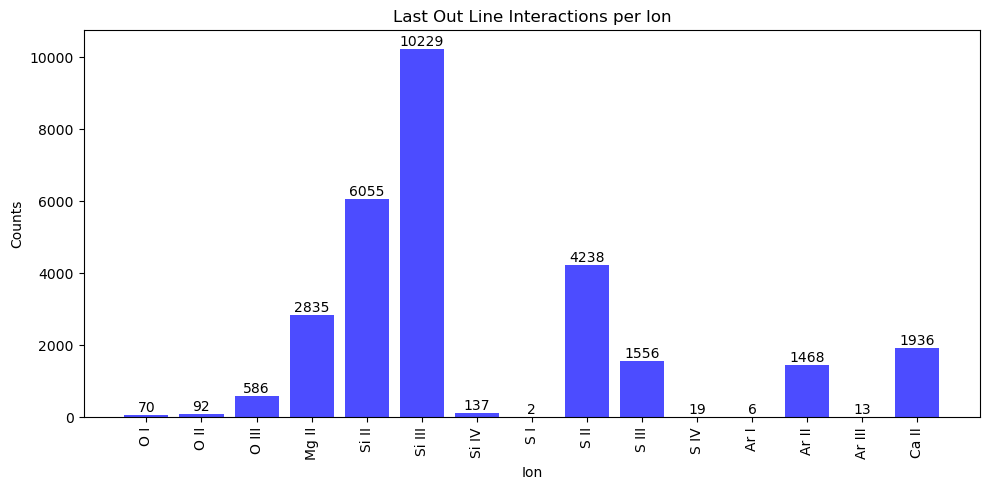

In [13]:
## Note: Plotting only out_line_interactions

# Data
labels = out_line_count_by_element.index
values = out_line_count_by_element.values

# Positions for the bars on the x-axis
positions = np.arange(len(labels))

# Plotting
plt.figure(figsize=(10, 5))
bars = plt.bar(positions, values, align="center", alpha=0.7, color="b")

# Adding the text on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.05,
        yval,
        ha="center",
        va="bottom",
    )

plt.xticks(positions, labels, rotation="vertical")
plt.xlabel("Ion")
plt.ylabel("Counts")
plt.title("Last Out Line Interactions per Ion")

plt.tight_layout()
plt.show()